In [95]:
from csoundengine.offline import OfflineEngine
e = OfflineEngine(outfile="~/tmp/pitchtrack.wav")

e.compile(r'''
instr pitchtrackvoice
    isndtable, ifreqtable, iminfreq, imaxfreq, ifftsize, ihopfactor, iwinsizefactor, ifftoversample, imindb, idbrange passign 4
	kfreq init 0.001
	kfreq0 init 0
	achannels[] = loscilx(1, 1, isndtable, 4, 1)
	a0 = achannels[0]
	iwinsize = ifftsize * iwinsizefactor
	ioverlap = int(iwinsize * ihopfactor)
	ifftsize2 = ifftsize * ifftoversample
	; a0d = delay(a0, ifftsize2 * iwinsizefactor * 0.5 / sr)
    a0d = a0
	a0anal = butlp(butlp(a0, imaxfreq * 7), imaxfreq*7)
	a0danal = butlp(butlp(a0d, imaxfreq * 7), imaxfreq * 7)
	afol = follow2(a0, 0.01, 0.1)
	kgate = schmitt(dbamp(rms(afol)), imindb+idbrange, imindb-idbrange) 
	fsig1 = pvsanal(a0danal, ifftsize, ioverlap, iwinsize, 0)
	fsigfeat = pvsanal(a0, ifftsize, ioverlap, iwinsize, 0)
	fsig2 = pvsanal(a0anal, ifftsize2, ioverlap, ifftsize2 * iwinsizefactor, 0)
	kfreq1, kamp1 pvspitch fsig1, ampdb(imindb) 
	kfreq2, kamp2 pvspitch fsig1, ampdb(imindb + idbrange*1.5)
	kfreq3, kamp3 pvspitch fsig2, ampdb(imindb + idbrange)
	
	kflatness = pvsflatness(fsigfeat, 50)
	kflatness = pow(kflatness, 1.5)
	kentropy0 pvsentropy fsigfeat, 50
	kentropy = bpf:k(kentropy0, 0, 0, 0.55, 0, 6, .15, 20, .5, 60, .9, 180, 1.)
	kpeakyness = pvsmagsumn(fsigfeat, 50, 50) / max(0.000000001, pvsmagsum(fsigfeat))
	kunpeakyness = 1 - kpeakyness
	knoisyness = sqrt(kflatness*kflatness + kentropy*kentropy + kunpeakyness*kunpeakyness)
	 
	kt = eventtime()
	kcount = eventcycles()
	ifreqtablesize = ftlen(ifreqtable)
	if kcount >= ifreqtablesize || detectsilence(a0, db(-90), 0.5) == 1 then
		turnoff
	endif
	kvalid1 = kfreq1 > iminfreq && kfreq1 < imaxfreq ? 1 : 0
	kvalid2 = kfreq2 > iminfreq && kfreq2 < imaxfreq ? 1 : 0
	kvalid3 = kfreq3 > iminfreq && kfreq3 < imaxfreq ? 1 : 0
	
	ksource = 1
    ; First choose between freq1 and freq2
	if kvalid1 == 0 && kvalid2 == 0 then
		kfreq1 = 0
	elseif kvalid1 == 1 && kvalid2 == 1 && abs(kfreq1 - kfreq2)/(kfreq1+kfreq2) > 0.1 then
		kfreq1pre = kfreq1
        ; take the nearest freq. to the last measurement
		kfreq1 = abs(kfreq1 - kfreq) < abs(kfreq2 - kfreq) ? kfreq1 : kfreq2
	elseif kvalid1 == 0 && kvalid2 == 1 then
		kfreq1 = kfreq2
	elseif kvalid1 == 1 && kvalid2 == 0 then
		kfreq1 = 0
		kvalid1 = 0
	endif

    ; now choose between the last value and freq3
	if kvalid1 == 0 && kvalid3 == 1 && kfreq0 > 0 then
		if abs(kfreq3 - kfreq) / kfreq < 0.1 then
			ksource = 2
		endif
	elseif kvalid1 == 1 && kvalid3 == 1 && abs(kfreq1 - kfreq3) / kfreq > 0.25 then
		ksource = abs(kfreq1 - kfreq) < abs(kfreq3 - kfreq) ? 1 : 2
	endif

    kfreq0prev = kfreq0
	kfreq0 = ksource == 1 ? kfreq1 : kfreq3
    
    if kfreq0 > 70 then
		kfreq0cont = mtof(lagud(ftom(kfreq0), 0.02, 0.04))
        kfreq = kfreq0prev == 0 ? kfreq0 : kfreq0cont
    endif
    knoisegate = schmitt(knoisyness, 0.7, 0.5)
	kgate = kgate * (kfreq0 > 0 ? 1 : 0) * (1 - knoisegate)
	; kgate = max(trighold(kgate, 0.1), kgate)
	iatt = 0.03
	irel = 0.03
	aenv = lagud:a(interp(kgate), iatt, irel)
    ; TODO
	
	asig = buzz(aenv, kfreq, 7, -1)
    asig *= aenv
    asig *= aenv
    
    ; asig = oscili:a(aenv, kfreq)
	
	outch 1, delay(a0, ifftsize / sr)
	outch 2, asig

    kidx = kcount*6 + 1
    tabw kfreq * kgate, kidx, ifreqtable
    tabw kt, kidx+1, ifreqtable
    tabw kgate, kidx+2, ifreqtable
    tabw kfreq1, kidx+3, ifreqtable
    tabw kfreq2, kidx+4, ifreqtable
    tabw kfreq3, kidx+5, ifreqtable
    
	tabw kcount, 0, ifreqtable
    
endin
''')


--Csound version 7.0 (double samples) Oct 28 2025
[commit: 15afda0ba81a895a4e87ac3ef5fe476702b072bf]
using libsndfile-1.2.2
sr = 44100.0, kr = 689.062, ksmps = 64
0dBFS level = 1.0, A4 tuning = 440.0
audio buffered in 256 sample-frame blocks
writing 1024-byte blks of shorts to /home/em/tmp/pitchtrack.wav (WAV)
SECTION 1:


In [96]:
sndtab = e.readSoundfile("/home/em/Lib/snd/samples/speech/voiceover-fragment.flac")
# sndtab = e.readSoundfile("/home/em/Lib/snd/samples/speech/finneganswake-fragm01.flac")
sndtabinfo = e.tableInfo(sndtab)
duration = sndtabinfo.duration
numcycles = int(duration * e.sr / e.ksmps)
numcols = 6
freqtab = e.makeEmptyTable((numcycles + 100) * numcols)
print(f"Duration: {sndtabinfo.duration:.3f}")

e.sched('pitchtrackvoice', 0, duration + 0.1, sndtab, freqtab, 60, 300, 1024, 1/4, 1, 3, -45, 12)
e.perform()

# Now retrieve information
outarr = e.getTableData(freqtab)
datalen = int(outarr[0])
freqs = outarr[1:1+datalen*numcols:numcols]
times = outarr[2:1+datalen*numcols:numcols]
noises = outarr[3:1+datalen*numcols:numcols]
freqs1 = outarr[4:1+datalen*numcols:numcols]
freqs2 = outarr[5:1+datalen*numcols:numcols]
freqs3 = outarr[6:1+datalen*numcols:numcols]


freqs[freqs==0] = float("nan")
freqs2[freqs2>500] = float("nan")
freqs3[freqs3>500] = float("nan")

Duration: 8.926


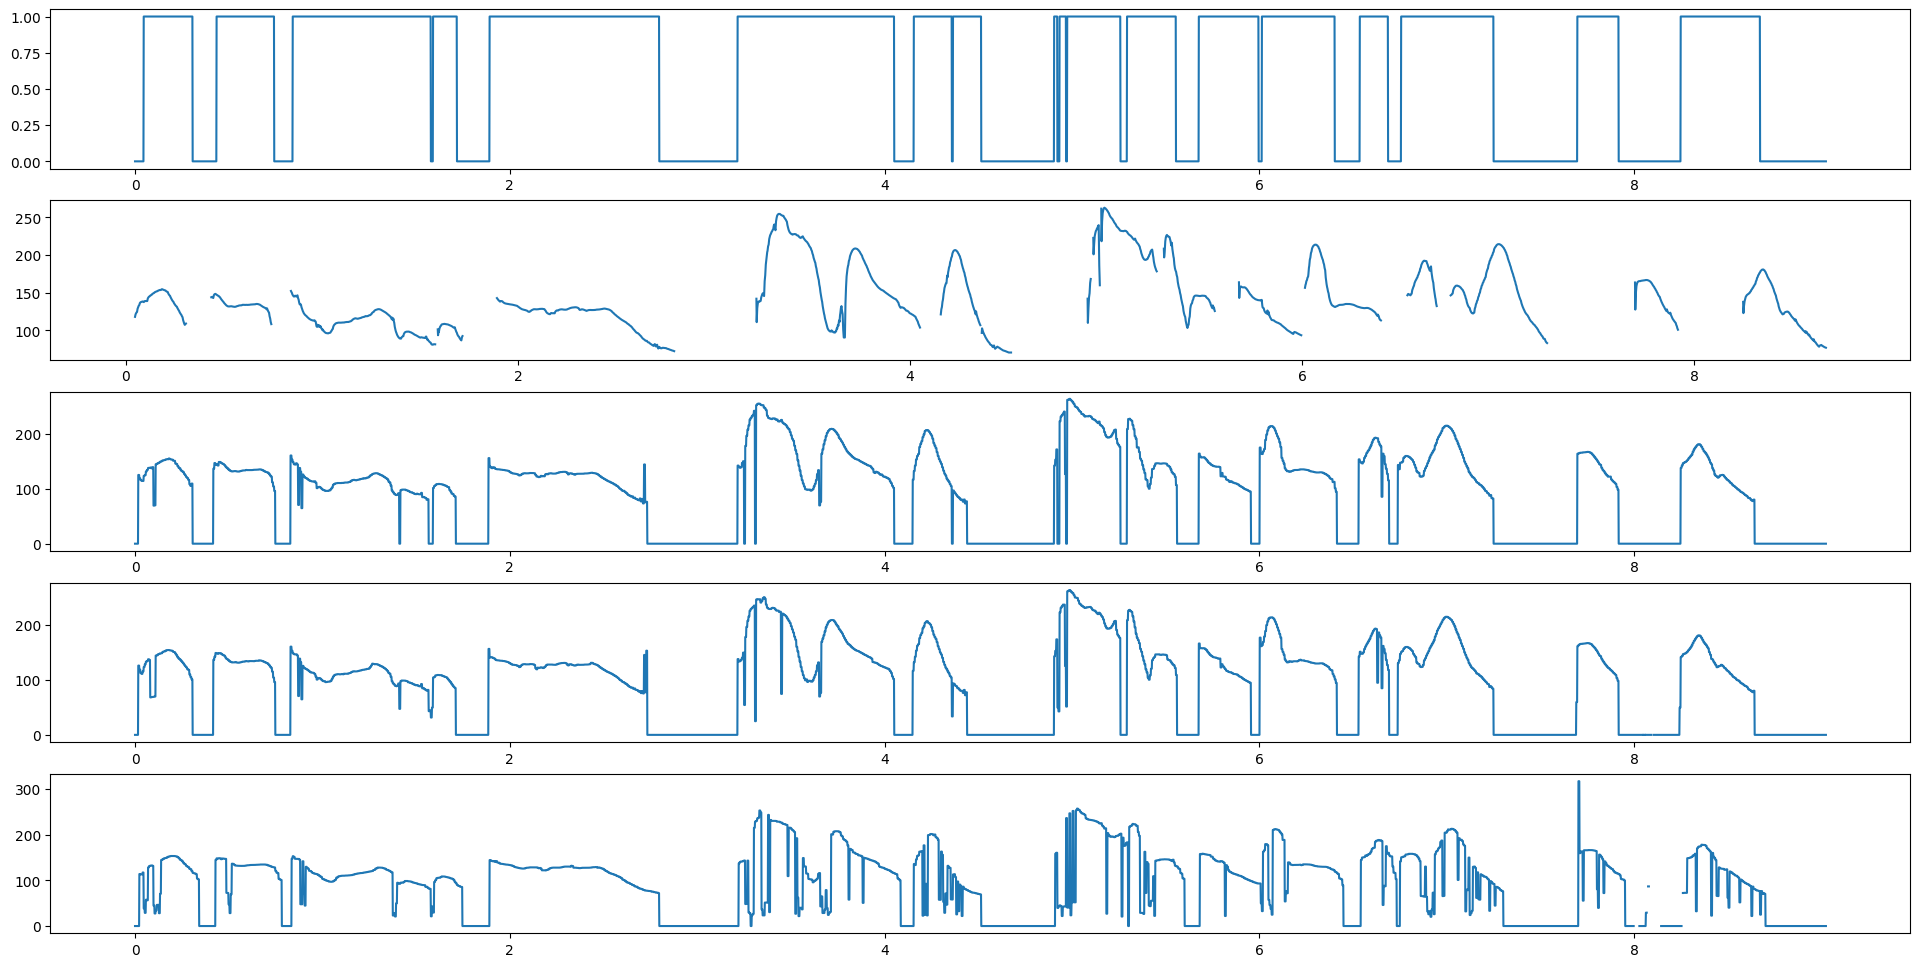

In [97]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(5, 1, figsize=(24, 12))
axs[1].plot(times, freqs)
axs[0].plot(times, noises)
axs[2].plot(times, freqs1)
axs[3].plot(times, freqs2)
axs[4].plot(times, freqs3)




resetting Csound instance
		   overall amps:  0.96874  1.00000
	   overall samples out of range:        0        0
0 errors in performance
512 1024 sample blks of shorts written to /home/em/tmp/pitchtrack.wav (WAV)


RenderJob(outfile='/home/em/tmp/pitchtrack.wav', samplerate=44100, encoding='float32', starttime=0.0, endtime=0.0, process=None)
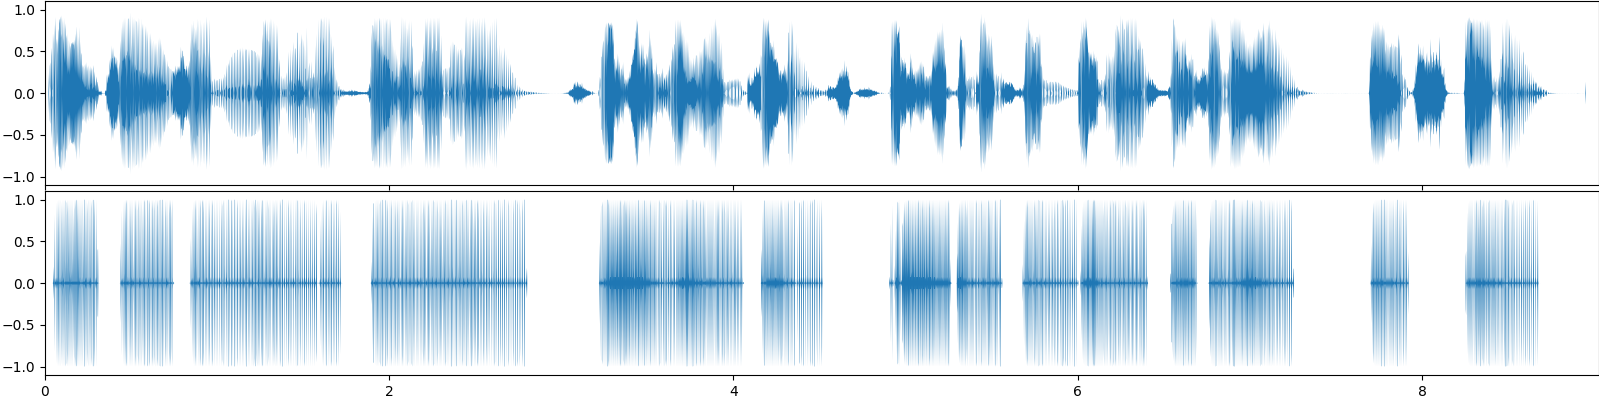

In [98]:
job = e.stop()
job

In [ ]:
job.

virtual const QPalette* Qt6CTPlatformTheme::palette(QPlatformTheme::Palette) const QPlatformTheme::SystemPalette
virtual const QPalette* Qt6CTPlatformTheme::palette(QPlatformTheme::Palette) const QPlatformTheme::ToolButtonPalette
virtual const QPalette* Qt6CTPlatformTheme::palette(QPlatformTheme::Palette) const QPlatformTheme::ButtonPalette
virtual const QPalette* Qt6CTPlatformTheme::palette(QPlatformTheme::Palette) const QPlatformTheme::CheckBoxPalette
virtual const QPalette* Qt6CTPlatformTheme::palette(QPlatformTheme::Palette) const QPlatformTheme::RadioButtonPalette
virtual const QPalette* Qt6CTPlatformTheme::palette(QPlatformTheme::Palette) const QPlatformTheme::HeaderPalette
virtual const QPalette* Qt6CTPlatformTheme::palette(QPlatformTheme::Palette) const QPlatformTheme::ItemViewPalette
virtual const QPalette* Qt6CTPlatformTheme::palette(QPlatformTheme::Palette) const QPlatformTheme::MessageBoxLabelPelette
virtual const QPalette* Qt6CTPlatformTheme::palette(QPlatformTheme::Palett

backtrace() returned 61 addresses
/usr/local/lib/libcsound64.so(+0x38cf0) [0x7b53ca838cf0]
/lib/x86_64-linux-gnu/libc.so.6(+0x458d0) [0x7b540dc458d0]
/lib/x86_64-linux-gnu/libc.so.6(pthread_kill+0x11c) [0x7b540dca49bc]
/lib/x86_64-linux-gnu/libc.so.6(gsignal+0x1e) [0x7b540dc4579e]
/lib/x86_64-linux-gnu/libc.so.6(abort+0x2c) [0x7b540dc288cd]
/lib/x86_64-linux-gnu/libc.so.6(__assert_perror_fail+0) [0x7b540dc28830]
/lib/x86_64-linux-gnu/libX11.so.6(+0x433ab) [0x7b53c8eda3ab]
/lib/x86_64-linux-gnu/libX11.so.6(_XSend+0x8f) [0x7b53c8ede7cf]
/lib/x86_64-linux-gnu/libX11.so.6(XQueryExtension+0xab) [0x7b53c8ed130b]
/lib/x86_64-linux-gnu/libX11.so.6(XInitExtension+0x3c) [0x7b53c8ec573c]
/lib/x86_64-linux-gnu/libXrender.so.1(XRenderFindDisplay+0x1b9) [0x7b53c73c4e99]
/lib/x86_64-linux-gnu/libXrender.so.1(XRenderQueryExtension+0x16) [0x7b53c73c9746]
/lib/x86_64-linux-gnu/libXcursor.so.1(_XcursorGetDisplayInfo+0x14a) [0x7b53c816232a]
/lib/x86_64-linux-gnu/libXcursor.so.1(XcursorSupportsARGB+0xd) [0

		   overall amps:      0.0
	   overall samples out of range:        0
0 errors in performance
Elapsed time at end of performance: real: 12.928s, CPU: 2.077s
		   overall amps:      0.0
	   overall samples out of range:        0
0 errors in performance
Elapsed time at end of performance: real: 38976.903s, CPU: 5.534s
		   overall amps:      0.0
	   overall samples out of range:        0
0 errors in performance
Elapsed time at end of performance: real: 39002.979s, CPU: 7.645s
		   overall amps:      0.0
	   overall samples out of range:        0
0 errors in performance
Elapsed time at end of performance: real: 39091.628s, CPU: 10.268s
		   overall amps:      0.0
	   overall samples out of range:        0
0 errors in performance
Elapsed time at end of performance: real: 39938.964s, CPU: 12.407s
		   overall amps:  0.96874  1.00000
	   overall samples out of range:        0        0
0 errors in performance
512 1024 sample blks of shorts written to /tmp/csoundengine-x8h97dcc.wav (WAV)
		  